# Ride Share Analytics

Aman Chaudhary and Rahul Devajji

We have a dataset of rides taken by people in three major American cities - **Chicago**, **New York** and **Washington**.

Out of the three cities, Washington does not have the `Gender` and `Birth Year` columns.

Our primary goal is to predict these two (Categorical and Ordinal) columns for the city of **Washington** by training a machine learning model with the **Chicago** and **New York** data. 

## Import Dependencies

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.formula.api import ols
from datetime import datetime
from matplotlib.pyplot import figure

pd.set_option('mode.chained_assignment', None)

## Pre-processing

In [225]:
chicago_df = pd.read_csv('./dataset/chicago.csv')
chicago_df.head(2)

,Unnamed: 0,Start Time,End Time,Trip Duration,Start Station,End Station,User Type,Gender,Birth Year
0,1423854,2017-06-23 15:09:32,2017-06-23 15:14:53,321,Wood St & Hubbard St,Damen Ave & Chicago Ave,Subscriber,Male,1992.0
1,955915,2017-05-25 18:19:03,2017-05-25 18:45:53,1610,Theater on the Lake,Sheffield Ave & Waveland Ave,Subscriber,Female,1992.0


In [226]:
newyork_df = pd.read_csv('./dataset/new_york_city.csv')
newyork_df.head(2)

,Unnamed: 0,Start Time,End Time,Trip Duration,Start Station,End Station,User Type,Gender,Birth Year
0,5688089,2017-06-11 14:55:05,2017-06-11 15:08:21,795,Suffolk St & Stanton St,W Broadway & Spring St,Subscriber,Male,1998.0
1,4096714,2017-05-11 15:30:11,2017-05-11 15:41:43,692,Lexington Ave & E 63 St,1 Ave & E 78 St,Subscriber,Male,1981.0


In [227]:
washington_df = pd.read_csv('./dataset/washington.csv')
washington_df.head(2)

,Unnamed: 0,Start Time,End Time,Trip Duration,Start Station,End Station,User Type
0,1621326,2017-06-21 08:36:34,2017-06-21 08:44:43,489.066,14th & Belmont St NW,15th & K St NW,Subscriber
1,482740,2017-03-11 10:40:00,2017-03-11 10:46:00,402.549,Yuma St & Tenley Circle NW,Connecticut Ave & Yuma St NW,Subscriber


#### Renaming the columns by snake_case

In [228]:
chicago_df = chicago_df.rename({'Unnamed: 0': 'ride_id'}, axis = 1)
chicago_df.columns= chicago_df.columns.str.strip().str.lower()
chicago_df.columns= chicago_df.columns.str.replace(' ','_')

newyork_df = newyork_df.rename({'Unnamed: 0': 'ride_id'}, axis = 1)
newyork_df.columns= newyork_df.columns.str.strip().str.lower()
newyork_df.columns= newyork_df.columns.str.replace(' ','_')

washington_df = washington_df.rename({'Unnamed: 0': 'ride_id'}, axis = 1)
washington_df.columns= washington_df.columns.str.strip().str.lower()
washington_df.columns= washington_df.columns.str.replace(' ','_')

In [229]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ride_id        300000 non-null  int64  
 1   start_time     300000 non-null  object 
 2   end_time       300000 non-null  object 
 3   trip_duration  300000 non-null  int64  
 4   start_station  300000 non-null  object 
 5   end_station    300000 non-null  object 
 6   user_type      300000 non-null  object 
 7   gender         238948 non-null  object 
 8   birth_year     238981 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 20.6+ MB


In [230]:
newyork_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ride_id        300000 non-null  int64  
 1   start_time     300000 non-null  object 
 2   end_time       300000 non-null  object 
 3   trip_duration  300000 non-null  int64  
 4   start_station  300000 non-null  object 
 5   end_station    300000 non-null  object 
 6   user_type      299308 non-null  object 
 7   gender         270791 non-null  object 
 8   birth_year     271780 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 20.6+ MB


#### Since the gender and birth year is not something we can fix by interpolation/extrapolation, so we will delete those rows.

In [231]:
na_free = chicago_df.dropna()
chicago_only_na = chicago_df[~chicago_df.index.isin(na_free.index)]

In [232]:
na_free = newyork_df.dropna()
newyork_only_na = newyork_df[~newyork_df.index.isin(na_free.index)]

In [233]:
chicago_df = chicago_df.dropna()
newyork_df = newyork_df.dropna()
washington_df = washington_df.dropna()

#### Converting `birth_year` into int

In [234]:
chicago_df.birth_year = chicago_df.birth_year.astype(int)
newyork_df.birth_year = newyork_df.birth_year.astype(int)

#### Restricting the rows to age <= 105

In [235]:
chicago_df['age'] = chicago_df.apply(lambda x: datetime.now().year - x['birth_year'], axis=1)
newyork_df['age'] = newyork_df.apply(lambda x: datetime.now().year - x['birth_year'], axis=1)

In [236]:
print(len(chicago_df.query('age >= 100')), len(chicago_df.query('age >= 105')))
chicago_df.age.describe()

132 54


count    238948.000000
mean         40.141658
std          11.004084
min           5.000000
25%          32.000000
50%          37.000000
75%          46.000000
max         122.000000
Name: age, dtype: float64

In [237]:
chicago_df = chicago_df.query('age <= 105')
newyork_df = newyork_df.query('age <= 105')

#### Converting gender and user_type to categorical data type

In [238]:
chicago_df.gender = chicago_df.gender.astype('category')
chicago_df.user_type = chicago_df.user_type.astype('category')

newyork_df.gender = pd.Categorical(newyork_df.gender)
newyork_df.user_type = pd.Categorical(newyork_df.user_type)

#### Converting `start_time` and `end_time` to datetime

In [239]:
chicago_df['start_time'] = pd.to_datetime(chicago_df['start_time'])
chicago_df['end_time'] = pd.to_datetime(chicago_df['end_time'])

newyork_df['start_time'] = pd.to_datetime(newyork_df['start_time'])
newyork_df['end_time'] = pd.to_datetime(newyork_df['end_time'])

washington_df['start_time'] = pd.to_datetime(washington_df['start_time'])
washington_df['end_time'] = pd.to_datetime(washington_df['end_time'])

In [240]:
chicago_cleaned_df = chicago_df.copy()
newyork_cleaned_df = newyork_df.copy()
washington_cleaned_df = washington_df.copy()

## Exploratory Data Analysis

In [241]:
chicago_cleaned_df

,ride_id,start_time,end_time,trip_duration,start_station,end_station,user_type,gender,birth_year,age
0,1423854,2017-06-23 15:09:32,2017-06-23 15:14:53,321,Wood St & Hubbard St,Damen Ave & Chicago Ave,Subscriber,Male,1992,29
1,955915,2017-05-25 18:19:03,2017-05-25 18:45:53,1610,Theater on the Lake,Sheffield Ave & Waveland Ave,Subscriber,Female,1992,29
2,9031,2017-01-04 08:27:49,2017-01-04 08:34:45,416,May St & Taylor St,Wood St & Taylor St,Subscriber,Male,1981,40
3,304487,2017-03-06 13:49:38,2017-03-06 13:55:28,350,Christiana Ave & Lawrence Ave,St. Louis Ave & Balmoral Ave,Subscriber,Male,1986,35
4,45207,2017-01-17 14:53:07,2017-01-17 15:02:01,534,Clark St & Randolph St,Desplaines St & Jackson Blvd,Subscriber,Male,1975,46
...,...,...,...,...,...,...,...,...,...,...
299992,1327248,2017-06-17 16:44:16,2017-06-17 16:50:57,401,Sheffield Ave & Willow St,Halsted St & Dickens Ave,Subscriber,Male,1955,66
299994,935129,2017-05-23 17:08:04,2017-05-23 17:11:37,213,Indiana Ave & 31st St,MLK Jr Dr & 29th St,Subscriber,Male,1988,33
299995,64825,2017-01-21 13:18:00,2017-01-21 13:27:50,590,Orleans St & Elm St (*),Sheffield Ave & Webster Ave,Subscriber,Male,1965,56
299997,159685,2017-02-12 09:59:01,2017-02-12 10:21:49,1368,Ravenswood Ave & Lawrence Ave,Stockton Dr & Wrightwood Ave,Subscriber,Female,1988,33


#### Exploring the distribution of age

In [242]:
age_bins = [0,30, 40, 50, 60, 105]
age_labels = ['<=30','30<age<=40','40<age<=50', '50<age<=60', '60<age<=105']

age_categories_chicago = pd.cut(
    chicago_cleaned_df.age,
    bins=age_bins,
    labels=age_labels
)

age_categories_newyork = pd.cut(
    newyork_cleaned_df.age,
    bins=age_bins,
    labels=age_labels
)

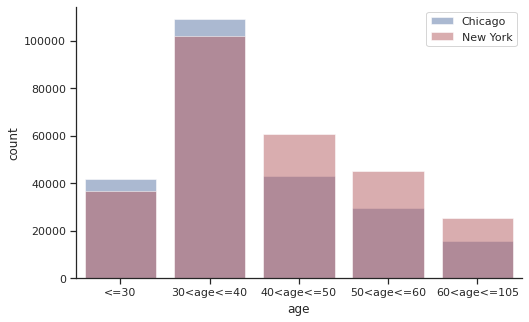

In [243]:
fig, ax = plt.subplots(figsize=(8, 5), sharey=True, sharex=True)

sns.countplot(
    x=age_categories_chicago,
    ax=ax,
    color='b',
    alpha=0.5,
    label='Chicago'
)

sns.countplot(
    x=age_categories_newyork,
    ax=ax,
    color='r',
    alpha=0.5,
    label='New York'
)

plt.legend();

#### Exploring the correlation between `age` and `gender` in chicago and new york

In [244]:
chicago_males = chicago_cleaned_df.query('gender == "Male"')
chicago_females = chicago_cleaned_df.query('gender == "Female"')

newyork_males = newyork_cleaned_df.query('gender == "Male"')
newyork_females = newyork_cleaned_df.query('gender == "Female"')

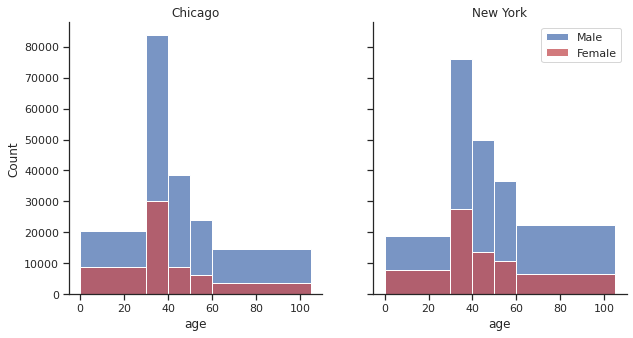

In [245]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(
    x=chicago_males.age,
    bins=age_bins,
    ax=ax1,
    color='b',
    label='Male'
)

sns.histplot(
    x=chicago_females.age,
    bins=age_bins,
    ax=ax1,
    color='r',
    label='Female'
)

sns.histplot(
    x=newyork_males.age,
    bins=age_bins,
    ax=ax2,
    color='b',
    label='Male'
)

sns.histplot(
    x=newyork_females.age,
    bins=age_bins,
    ax=ax2,
    color='r',
    label='Female'
)
ax1.set_title("Chicago")
ax2.set_title("New York")
plt.legend();

#### Exploring the correlation between `age` and `trip_duration` in chicago and new york

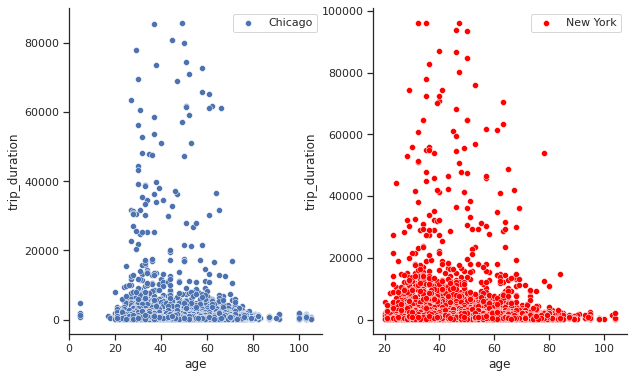

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1 = sns.scatterplot(
    data=chicago_cleaned_df,
    y="trip_duration",
    x="age",
    ax=ax1,
    label='Chicago'
);

ax2 = sns.scatterplot(
    data=newyork_cleaned_df[newyork_cleaned_df.trip_duration <= 1e5],
    y="trip_duration",
    x="age",
    ax=ax2,
    label='New York',
    color='red'
);

In [247]:
chicago_cleaned_df['trip_end_hour'] = chicago_cleaned_df['end_time'].dt.hour
newyork_cleaned_df['trip_end_hour'] = newyork_cleaned_df['end_time'].dt.hour
washington_cleaned_df['trip_end_hour'] = washington_cleaned_df['end_time'].dt.hour

chicago_cleaned_df['trip_day_night'] = chicago_cleaned_df.trip_end_hour.apply(
    lambda x: 0 if x >= 6 and x <= 18 else 1
)
newyork_cleaned_df['trip_day_night'] = newyork_cleaned_df.trip_end_hour.apply(
    lambda x: 0 if x >= 6 and x <= 18 else 1
)
washington_cleaned_df['trip_day_night'] = washington_cleaned_df.trip_end_hour.apply(
    lambda x: 0 if x >= 6 and x <= 18 else 1
)

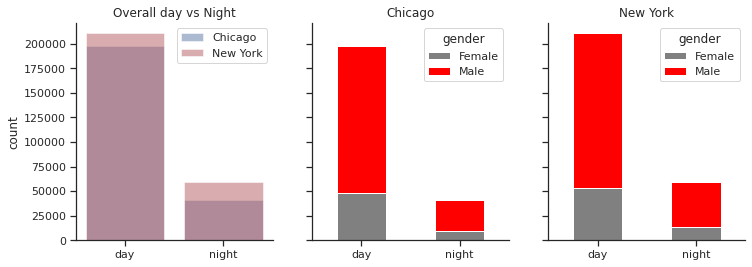

In [248]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sns.countplot(
    x=chicago_cleaned_df.trip_day_night,
    ax=ax1,
    color='b',
    alpha=0.5,
    label='Chicago'
)

sns.countplot(
    x=newyork_cleaned_df.trip_day_night,
    ax=ax1,
    color='r',
    alpha=0.5,
    label='New York'
)

chicago_cleaned_df.groupby(['trip_day_night', 'gender']).ride_id.count().T.unstack().plot(
    kind='bar',
    stacked=True,
    color=["grey", "red"],
    ax=ax2
)

newyork_cleaned_df.groupby(['trip_day_night', 'gender']).ride_id.count().T.unstack().plot(
    kind='bar',
    stacked=True,
    color=["grey", "red"],
    ax=ax3
)

ax1.set_xticklabels(labels=["day", "night"], rotation=0)
ax1.set_xlabel("")
ax1.set_title("Overall day vs Night");

ax2.set_xticklabels(labels=["day", "night"], rotation=0)
ax2.set_xlabel("")
ax2.set_title("Chicago");

ax3.set_xticklabels(labels=["day", "night"], rotation=0)
ax3.set_xlabel("")
ax3.set_title("New York");
ax1.legend();

In [249]:
chicago_cleaned_df['trip_duration_binary'] = chicago_cleaned_df['trip_duration'].apply(
    lambda x: 0 if x <= 700 else 1)

newyork_cleaned_df['trip_duration_binary'] = newyork_cleaned_df['trip_duration'].apply(
    lambda x: 0 if x <= 700 else 1)

washington_cleaned_df['trip_duration_binary'] = washington_cleaned_df['trip_duration'].apply(
    lambda x: 0 if x <= 700 else 1)

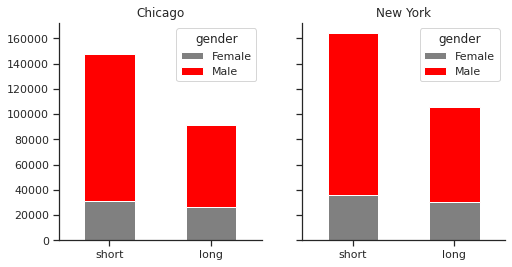

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
chicago_cleaned_df.groupby(['trip_duration_binary', 'gender']).ride_id.count().T.unstack().plot(
    kind='bar',
    stacked=True,
    color=["grey", "red"],
    ax=ax1
)

newyork_cleaned_df.groupby(['trip_duration_binary', 'gender']).ride_id.count().T.unstack().plot(
    kind='bar',
    stacked=True,
    color=["grey", "red"],
    ax=ax2
)

ax1.set_xticklabels(labels=["short", "long"], rotation=0)
ax1.set_xlabel("")
ax1.set_title("Chicago");
ax2.set_xticklabels(labels=["short", "long"], rotation=0)
ax2.set_xlabel("")
ax2.set_title("New York");

males and females both prefer shorter drives over longer drives

In [251]:
print('Males in Chicago = ', len(chicago_males))
print('Females in Chicago = ', len(chicago_females))
print('Ratio:', len(chicago_males) / len(chicago_females))

Males in Chicago =  181141
Females in Chicago =  57758
Ratio: 3.136206239828249


In [252]:
print('Males in Newyork = ', len(newyork_males))
print('Females in Newyork = ', len(newyork_females))
print('Ratio:', len(newyork_males) / len(newyork_females))

Males in Newyork =  203477
Females in Newyork =  66557
Ratio: 3.057184067791517


#### T-test and ANOVA

In [253]:
group1 = chicago_cleaned_df['trip_duration'][chicago_cleaned_df['gender'] == 'Male']
group2 = chicago_cleaned_df['trip_duration'][chicago_cleaned_df['gender'] == 'Female']
t_test = stats.ttest_ind(group1, group2)
print(f't: {t_test.statistic:.3f}, p: {t_test.pvalue:.3f}')
model = ols('trip_duration ~ gender', data=chicago_cleaned_df).fit()
sm.stats.anova_lm(model, typ=2)

t: -22.890, p: 0.000


,sum_sq,df,F,PR(>F)
gender,5.141940e+08,1.0,523.932665,7.870363e-116
Residual,2.344565e+11,238897.0,NaN,NaN


In [254]:
group1 = chicago_cleaned_df['trip_day_night'][chicago_cleaned_df['gender'] == 'Male']
group2 = chicago_cleaned_df['trip_day_night'][chicago_cleaned_df['gender'] == 'Female']
t_test = stats.ttest_ind(group1, group2)
print(f't: {t_test.statistic:.3f}, p: {t_test.pvalue:.3f}')
model = ols('trip_day_night ~ gender', data=chicago_cleaned_df).fit()
sm.stats.anova_lm(model, typ=2)

t: 2.897, p: 0.004


,sum_sq,df,F,PR(>F)
gender,1.190242,1.0,8.393973,0.003765
Residual,33874.940440,238897.0,NaN,NaN


In [255]:
group1 = chicago_cleaned_df['trip_end_hour'][chicago_cleaned_df['gender'] == 'Male']
group2 = chicago_cleaned_df['trip_end_hour'][chicago_cleaned_df['gender'] == 'Female']
t_test = stats.ttest_ind(group1, group2)
print(f't: {t_test.statistic:.3f}, p: {t_test.pvalue:.3f}')
model = ols('trip_end_hour ~ gender', data=chicago_cleaned_df).fit()
sm.stats.anova_lm(model, typ=2)

t: -3.847, p: 0.000


,sum_sq,df,F,PR(>F)
gender,3.423954e+02,1.0,14.802525,0.000119
Residual,5.525898e+06,238897.0,NaN,NaN


#### We see a significant correlation between the above chosen variables and gender. Hence can be used as accurate predictors.

# Regression Algorithms

### Importing Dependencies

In [256]:
from math import sqrt
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier
)
from sklearn.metrics import roc_auc_score, accuracy_score
RANDOM_STATE = 42

### Logistic Regression 

### Logistic Regression (Chicago)

In [257]:
chicago_cleaned_df['user_type_binary'] = chicago_cleaned_df['user_type'].apply(
    lambda x: 1 if x == 'Subscriber' else 0)

chicago_cleaned_df['gender_binary'] = chicago_cleaned_df['gender'].apply(
    lambda x: 1 if x == 'Female' else 0)

In [258]:
chicago_males = chicago_cleaned_df.query('gender == "Male"')
chicago_females = chicago_cleaned_df.query('gender == "Female"')

In [259]:
chicago_train = chicago_females.append(
    chicago_males.sample(int(len(chicago_females) * 1.2), random_state=RANDOM_STATE))
chicago_train.gender.value_counts()

Male      69309
Female    57758
Name: gender, dtype: int64

In [260]:
target = chicago_train[['gender_binary']]
features = chicago_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, train_size=0.9, random_state=RANDOM_STATE
)

chicago_logistic_regression = LogisticRegression()
chicago_logistic_regression.fit(X_train, y_train.values.ravel())
y_pred = chicago_logistic_regression.predict(X_train)

print(f'Accuracy score : {accuracy_score(y_pred, y_train)}')
print(pd.DataFrame(y_pred).value_counts())

Accuracy score : 0.559767401189227
0    101105
1     13255
dtype: int64


In [261]:
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = chicago_logistic_regression.predict(features)

print(f'Accuracy: {accuracy_score(y_pred, target)}')
pd.DataFrame(y_pred).value_counts()

prob_y_pred = chicago_logistic_regression.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

Accuracy: 0.24176744147108192
AUROC : 0.5012369904511736


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### Observations :-
- Using Logistic Regression, the predicted male to female ratio for Chicago is about $\mathbf{3.86 : 1}$.
- This prediction is very close to the actual ratio of $\mathbf{3.13 : 1}$.

### Logistic Regression (NewYork)

In [262]:
newyork_cleaned_df['user_type_binary'] = newyork_cleaned_df['user_type'].apply(
    lambda x: 1 if x == 'Subscriber' else 0)

newyork_cleaned_df['gender_binary'] = newyork_cleaned_df['gender'].apply(
    lambda x: 1 if x == 'Female' else 0)

In [263]:
newyork_males = newyork_cleaned_df.query('gender == "Male"')
newyork_females = newyork_cleaned_df.query('gender == "Female"')

In [264]:
newyork_train = newyork_females.append(
    newyork_males.sample(
        int(len(newyork_females) * 1.2),
        random_state=RANDOM_STATE
    )
)
newyork_train.gender.value_counts()

Male      79868
Female    66557
Name: gender, dtype: int64

In [265]:
target = newyork_train[['gender_binary']]
features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

newyork_logistic_regression = LogisticRegression()
newyork_logistic_regression.fit(X_train, y_train.values.ravel())
y_pred = newyork_logistic_regression.predict(X_train)
print(mean_squared_error(y_pred, y_train), accuracy_score(y_pred, y_train))
pd.DataFrame(y_pred).value_counts()

0.45755110713147473 0.5424488928685253


0    129088
1      2694
dtype: int64

In [266]:
target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = newyork_logistic_regression.predict(features)

print(f'Accuracy score : {accuracy_score(y_pred, target)}')
print(pd.DataFrame(y_pred).value_counts())
prob_y_pred = newyork_logistic_regression.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

Accuracy score : 0.7422806017020079
0    264438
1      5596
dtype: int64
AUROC : 0.5259458021678607


In [267]:
newyork_cleaned_df.gender.value_counts()

Male      203477
Female     66557
Name: gender, dtype: int64

#### Observations :-
- Using Logistic Regression, the predicted male to female ratio for New York is about $\mathbf{3.13 : 1}$.
- This prediction is very close to the actual ratio of $\mathbf{3.13 : 1}$.

## Decision Tree

In [268]:
decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    random_state=RANDOM_STATE,
    splitter='best',
    max_leaf_nodes=5,
)

### Decision Tree (Chicago)

In [269]:
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(decision_tree, features, target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

decision_tree.fit(X_train, y_train);

features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

target = chicago_train[['gender_binary']]
features = chicago_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)


target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
y_pred = decision_tree.predict(features)
print(pd.DataFrame(y_pred).value_counts())
prob_y_pred = decision_tree.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}, Accuracy score : {accuracy_score(y_pred, target)}')

Mean ROC AUC: 0.565
0    187630
1     51269
dtype: int64
AUROC : 0.5632718732305986, Accuracy score : 0.6768215856910242


#### Cost-sensitive decision tree

In [270]:
weights = {0:3.0, 1:1.0}
cs_decision_tree = DecisionTreeClassifier(
    class_weight=weights,
    criterion='entropy',
    max_depth=3,
)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

scores = cross_val_score(cs_decision_tree, features, target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.568


In [271]:
balance = [{0:1, 1:1}, {0:1, 1:1.1}, {0:1, 1:1.2}, {0:1, 1:1.3}, {0:1, 1:1.4}, {0:3.13, 1:1}, {0:1, 1: 3.13}, {0:1, 1:10}, {0:1, 1:100}]
param_grid = dict(class_weight=balance)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(features, target)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.514694 using {'class_weight': {0: 1, 1: 1.1}}
0.514436 (0.003486) with: {'class_weight': {0: 1, 1: 1}}
0.514694 (0.003468) with: {'class_weight': {0: 1, 1: 1.1}}
0.514107 (0.003528) with: {'class_weight': {0: 1, 1: 1.2}}
0.514452 (0.003434) with: {'class_weight': {0: 1, 1: 1.3}}
0.513981 (0.003394) with: {'class_weight': {0: 1, 1: 1.4}}
0.514397 (0.003239) with: {'class_weight': {0: 3.13, 1: 1}}
0.514183 (0.003294) with: {'class_weight': {0: 1, 1: 3.13}}
0.514421 (0.003169) with: {'class_weight': {0: 1, 1: 10}}
0.514397 (0.003283) with: {'class_weight': {0: 1, 1: 100}}


#### Observations :-
- Using Decision Tree, the male to female ratio for Chicago is about **26.04 : 1**.
- This predcition is not even close to the actual ratio of number of males to females in Chicago.

### Decision Tree (NewYork)

In [272]:
target = newyork_train[['gender_binary']]
features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

decision_tree.fit(X_train, y_train);

features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = decision_tree.predict(features)
print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')
target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = decision_tree.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    108317
1     38108
dtype: int64
Accuracy score : 0.5585111831995903
AUROC : 0.5610337411643391


In [273]:
balance = [{0:1, 1:1}, {0:1, 1:1.1}, {0:1, 1:1.2}, {0:1, 1:1.3}, {0:1, 1:1.4}, {0:3.13, 1:1}, {0:1, 1: 3.13}, {0:1, 1:10}, {0:1, 1:100}]
param_grid = dict(class_weight=balance)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
grid_result = grid.fit(features, target)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.512240 using {'class_weight': {0: 3.13, 1: 1}}
0.512106 (0.003472) with: {'class_weight': {0: 1, 1: 1}}
0.511972 (0.003680) with: {'class_weight': {0: 1, 1: 1.1}}
0.511710 (0.003651) with: {'class_weight': {0: 1, 1: 1.2}}
0.511983 (0.003642) with: {'class_weight': {0: 1, 1: 1.3}}
0.511718 (0.003741) with: {'class_weight': {0: 1, 1: 1.4}}
0.512240 (0.003556) with: {'class_weight': {0: 3.13, 1: 1}}
0.511944 (0.003586) with: {'class_weight': {0: 1, 1: 3.13}}
0.511473 (0.003621) with: {'class_weight': {0: 1, 1: 10}}
0.511817 (0.003522) with: {'class_weight': {0: 1, 1: 100}}


#### Observations :-
- Using Decision Tree, the male to female ratio for NewYork is about **9.93 : 1**).
- This predcition is not even close to the actual ratio of number of males to females in NewYork.

## ADABoost

In [274]:
ada_clf = AdaBoostClassifier(
    base_estimator = decision_tree,
    n_estimators=150,
    learning_rate=0.1
)

### ADABoost (Chicago)

In [275]:
target = chicago_train[['gender_binary']]
features = chicago_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

ada_boost_model = ada_clf.fit(X_train, y_train.values.ravel())

features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
target = chicago_cleaned_df[['gender_binary']]
y_pred = ada_boost_model.predict(features)

print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = ada_clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    179360
1     59539
dtype: int64
Accuracy score : 0.6671187405556323
AUROC : 0.5837806779515755


#### Observations :-
- Using ADABoost, the male to female ratio for Chciago is about **8.24 : 1**.
- This predcition is not even close to the actual ratio of number of males to females in Chicago.

### ADABoost (New York)

In [276]:
target = newyork_train[['gender_binary']]
features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

ada_boost_model = ada_clf.fit(X_train, y_train.values.ravel())

features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
target = newyork_cleaned_df[['gender_binary']]
y_pred = ada_boost_model.predict(features)

print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = ada_clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    205532
1     64502
dtype: int64
Accuracy score : 0.6655124910196494
AUROC : 0.5773742582001129


#### Observations :-
- Using ADABoost, the male to female ratio for NewYork is about **4.18 : 1**.
- This predcition is close to the actual ratio of number of males to females in NewYork but still Logistic Regression gives us a better prediction.

## Bagging

In [277]:
bagging_classifier = BaggingClassifier(
base_estimator = decision_tree,
n_estimators = 200, 
max_samples = 10000,
random_state = RANDOM_STATE,
)

### Bagging (Chicago)

In [278]:
target = chicago_train[['gender_binary']]
features = chicago_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

model = bagging_classifier.fit(X_train, y_train.values.ravel())

y_pred = model.predict(chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
])

target = chicago_cleaned_df[['gender_binary']]
print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')

target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = bagging_classifier.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    177345
1     61554
dtype: int64
Accuracy score : 0.6596051050862498
AUROC : 0.5726674489674901


#### Observations :-
- Using Bagging, the male to female ratio for Chicago is about **17.78 : 1**.
- This predcition is not even close to the actual ratio of number of males to females in Chicago.

### Bagging (NewYork)

In [279]:
target = newyork_train[['gender_binary']]
features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

model = bagging_classifier.fit(X_train, y_train.values.ravel())

y_pred = model.predict(newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
])
target = newyork_cleaned_df[['gender_binary']]
print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = bagging_classifier.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    214351
1     55683
dtype: int64
Accuracy score : 0.6759889495396876
AUROC : 0.5701135959437491


#### Observations :-
- Using Bagging, the male to female ratio for NewYork is about **8.19 : 1**.
- This predcition is not even close to the actual ratio of number of males to females in NewYork.

## Random Forest

In [280]:
ranfor_clf = RandomForestClassifier(n_estimators=150)

target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

model = ranfor_clf.fit(X_train, y_train.values.ravel())

### Random Forest (Chicago)

In [281]:
y_pred = model.predict(chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
])
target = chicago_cleaned_df[['gender_binary']]
print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = ranfor_clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    222570
1     16329
dtype: int64
Accuracy score : 0.7796181649985977
AUROC : 0.7308937620916081


#### Observations :-
- Using Random Forest, the male to female ratio for Chicago is about **2.11 : 1**.
- This ratio of number of males to females in Chicago using Random Forest is coming less than the actual ratio in Chicago.

### Random Forest (NewYork)

In [282]:
target = newyork_train[['gender_binary']]
features = newyork_train[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)

model = ranfor_clf.fit(X_train, y_train.values.ravel())

y_pred = model.predict(newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
])
target = newyork_cleaned_df[['gender_binary']]

print(pd.DataFrame(y_pred).value_counts())
print(f'Accuracy score : {accuracy_score(y_pred, target)}')

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
prob_y_pred = ranfor_clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}')

0    163447
1    106587
dtype: int64
Accuracy score : 0.6554507950850633
AUROC : 0.6992390349426761


#### Observations :-
- Using Random Forest, the male to female ratio for NewYork is about **1.04 : 1**.
- This ratio of number of males to females in Chicago using Random Forest is coming less than the actual ratio in NewYork.

#### Therefore, Logistic Regression classifies the data best as the ratio of males to females in both Chicago and NewYork are almost identical to the actual ratio of number of males to number of males for both the dataframes.

In [283]:
washington_cleaned_df['user_type_binary'] = washington_cleaned_df['user_type'].apply(
    lambda x: 1 if x == 'Subscriber' else 0)

In [284]:
washington_cleaned_df.head()

,ride_id,start_time,end_time,trip_duration,start_station,end_station,user_type,trip_end_hour,trip_day_night,trip_duration_binary,user_type_binary
0,1621326,2017-06-21 08:36:34,2017-06-21 08:44:43,489.066,14th & Belmont St NW,15th & K St NW,Subscriber,8,0,0,1
1,482740,2017-03-11 10:40:00,2017-03-11 10:46:00,402.549,Yuma St & Tenley Circle NW,Connecticut Ave & Yuma St NW,Subscriber,10,0,0,1
2,1330037,2017-05-30 01:02:59,2017-05-30 01:13:37,637.251,17th St & Massachusetts Ave NW,5th & K St NW,Subscriber,1,1,0,1
3,665458,2017-04-02 07:48:35,2017-04-02 08:19:03,1827.341,Constitution Ave & 2nd St NW/DOL,M St & Pennsylvania Ave NW,Customer,8,0,1,0
4,1481135,2017-06-10 08:36:28,2017-06-10 09:02:17,1549.427,Henry Bacon Dr & Lincoln Memorial Circle NW,Maine Ave & 7th St SW,Subscriber,9,0,1,1


In [285]:
features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = newyork_logistic_regression.predict(features)
pd.DataFrame(y_pred).value_counts()

0    250288
1     49712
dtype: int64

In [286]:
washington_cleaned_df['gender_binary'] = y_pred

In [287]:
washington_cleaned_df['gender'] = washington_cleaned_df['gender_binary'].apply(
    lambda x: 'Female' if x == 1 else 'Male')

#### As we have noticed from above, our method of sampling was not optimal. We overfit for the models for the existing datasets and the prediction is not correct.

#### Below, we will try other methods to mitigate this class imbalance.

In [291]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [292]:
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)
clf = BalancedRandomForestClassifier(n_estimators=100,random_state=1)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(features)

prob_y_pred = clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, target)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.718973103126883
Accuracy Score : 0.6066747872531907


0    164632
1    135368
dtype: int64

In [293]:
target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)
clf = BalancedRandomForestClassifier(n_estimators=100,random_state=1)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(features)

prob_y_pred = clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, target)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.7270927909932088
Accuracy Score : 0.6080974988334802


1    156135
0    143865
dtype: int64

#### We notice that the AUROC is 0.71, so much better than the previous models when trained over the entire imbalanced dataset.

In [294]:
target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]
X, y = RandomUnderSampler().fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.7936384920708124
Accuracy Score : 0.7045990654626861


0    150671
1    149329
dtype: int64

In [97]:
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, train_size=0.9, random_state=RANDOM_STATE
)
clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(features)
print(pd.DataFrame(y_pred).value_counts())
prob_y_pred = clf.predict_proba(features)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(target, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, target)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

0    222520
1     16379
dtype: int64
AUROC : 0.7306399920436628
Accuracy Score : 0.779484217179645


0    273904
1     26096
dtype: int64

#### The Random forest classifier trained over the entire dataset is also giving us a better AUROC and accuracy values

In [297]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [298]:
rus = RandomUnderSampler(random_state=RANDOM_STATE, replacement=True)
target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X, y = rus.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.795192804769342
Accuracy Score : 0.7073565566674747


0    165663
1    134337
dtype: int64

In [299]:
rus = RandomUnderSampler(random_state=RANDOM_STATE, replacement=True)
target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X, y = rus.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.8060833679738882
Accuracy Score : 0.7158075033429993


1    162473
0    137527
dtype: int64

In [300]:
ros = RandomOverSampler()

target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X, y = ros.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.7610393101190556
Accuracy Score : 0.6811737817501283


0    202360
1     97640
dtype: int64

In [301]:
ros = RandomOverSampler()

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

X, y = ros.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.7749586614365696
Accuracy Score : 0.6913631516092728


0    187500
1    112500
dtype: int64

In [106]:
smote= SMOTE()

target = chicago_cleaned_df[['gender_binary']]
features = chicago_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

x, y = smote.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

0    181141
1    181141
dtype: int64
AUROC : 0.7605761302203
Accuracy Score : 0.6809446784549053


0    203932
1     96068
dtype: int64

In [302]:
smote= SMOTE()

target = newyork_cleaned_df[['gender_binary']]
features = newyork_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

x, y = smote.fit_resample(features, target.values.ravel())

clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

prob_y_pred = clf.predict_proba(X)
prob_y_pred = [p[1] for p in prob_y_pred]
print(f'AUROC : {roc_auc_score(y, prob_y_pred)}\nAccuracy Score : {accuracy_score(y_pred, y)}')

features = washington_cleaned_df[
    ['trip_duration','user_type_binary', 'trip_day_night', 'trip_end_hour']
]

y_pred = clf.predict(features)
pd.DataFrame(y_pred).value_counts()

AUROC : 0.7749677327720312
Accuracy Score : 0.6913729807300087


0    187606
1    112394
dtype: int64